# Тестирование полносвязной спайковой сети на MNIST

In [1]:
import numpy as np
import theano
import theano.tensor as T
import lasagne
import matplotlib.pyplot as plt
from multiprocessing import Pool
from multiprocessing.dummy import Pool as ThreadPool
import time
%matplotlib inline

In [2]:
%run ../SNN.ipynb

In [3]:
from mnist import load_dataset
X_train,y_train,X_val,y_val,X_test,y_test = load_dataset()

In [4]:
input_X = T.tensor4("X")
input_shape = [None,1,28,28]
target_y = T.vector("target Y integer",dtype='int32')

In [5]:
input_layer = lasagne.layers.InputLayer(shape = input_shape,input_var=input_X)

dense_1 = lasagne.layers.DenseLayer(input_layer, num_units=128, 
                                    nonlinearity=lasagne.nonlinearities.rectify,
                                   name='dense_1', b=None)

dense_2 = lasagne.layers.DenseLayer(dense_1, num_units=256, 
                                    nonlinearity=lasagne.nonlinearities.sigmoid,
                                   name='dense_2', b=None)

dense_3 = lasagne.layers.DenseLayer(dense_2, num_units=64, 
                                    nonlinearity=lasagne.nonlinearities.rectify,
                                   name='dense_2', b=None)

dense_output = lasagne.layers.DenseLayer(dense_3, num_units = 10,
                                        nonlinearity = lasagne.nonlinearities.softmax,
                                        name='output', b=None)

In [6]:
with np.load('dense_weights.npz') as f: 
    param_values = [f['arr_%d' % i] for i in range(len(f.files))] 
    for i in param_values[-1]:
        for j in i:
            j = abs(j)
    for i in param_values:
        for j in i:
            for k, n in enumerate(j):
                if(n < 0.000001):
                    j[k] = 0.0

    
#lasagne.layers.set_all_param_values(dense_output, param_values)

In [7]:
spiking_net = spiking_from_lasagne(dense_output)

In [10]:
right_first = right_freq = 0.
leng = 100
times = []
n = 1
for i in np.arange(n, n+leng):
    targ = y_train[i]
    start_time = time.time()
    ans = spiking_net.get_output_for([X_train[0,0]], 20)
    times.append(time.time() - start_time)
    if(i % 10 == 0):
        print(i)
    first_spike = n + 2*leng
    first_sp_ans = -1
    for k, j in enumerate(ans):
        if(len(j) > 0):
            if(j[0] < first_spike):
                first_spike = j[0]
                first_sp_ans = k
    if(k == targ):
        right_first += 1
    
    ans = [len(j) for j in ans]
    freq_max = 0
    freq_ans = -1
    for k, j in enumerate(ans):
        if (j > freq_max):
            freq_ans = k
            
    if(k == targ):
        right_freq += 1
        
print(right_first, right_freq)
print(right_first/leng, right_freq/leng)
print(np.mean(times))

10
(1.0, 1.0)
(0.1, 0.1)
8.26046869755


7


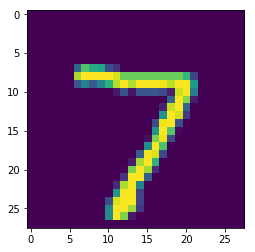

2


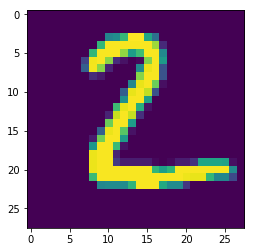

1


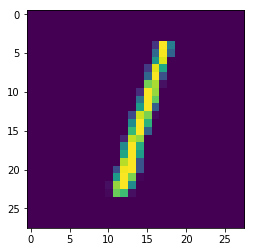

0


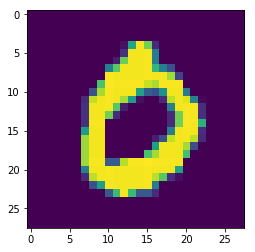

4


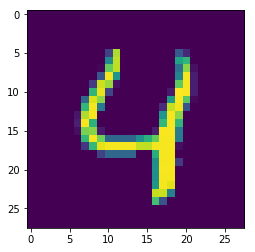

1


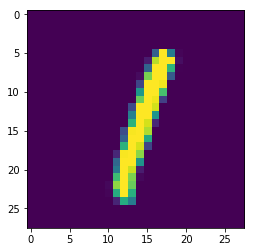

4


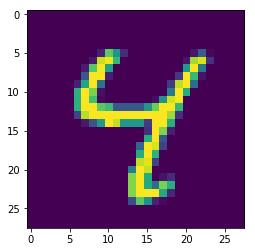

9


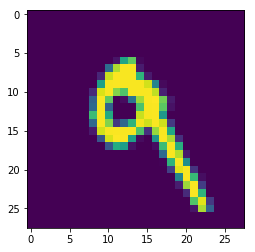

5


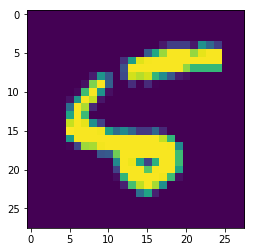

9


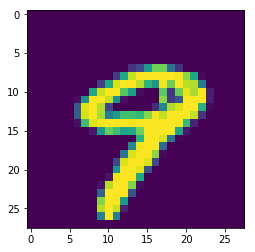

In [10]:
for i in np.arange(10):
    print(y_test[i])
    plt.imshow(X_test[i,0])
    plt.show()

In [28]:
params = [spiking_net.layers[i].weights.tolist() for i in np.arange(1, len(spiking_net.layers))]
par = " ".join(map(str, ["\n".join(map(str, [" ".join(map(str, ["%.6f" % k for k in j])) for j in i])) for i in params]))
#for i in params:
    #for j in i:
        #par+=str(" ".join(map(str, ["%.6f" % k for k in j])))+'\n'
        len(spiking_net.layers)
        i.neur_size for i in spiking_net.layers
    #par+='\n'

In [7]:
info = {'threshold':0.5, 'tau_m':4, 'tau_s':2, 'tau_r':20, 'layersNumber':444,
        'sizes':[4, 5, 6], 'synapsesPerConnection':1, 'spikesPerSynapse':2, 'exitTime':1000,\
        'weights':''}


In [11]:
f = open('params.txt', 'w')
f.writelines([i+': '+str(info[i])+'\n' for i in info])

In [12]:
for i in param_values:
    for j in i:
        f.writelines(str(" ".join(map(str, ["%.6f" % k for k in j])))+'\n')
f.close()

In [56]:
params = np.array([spiking_net.layers[i].weights.tolist() for i in np.arange(1, len(spiking_net.layers))])

In [60]:
len(params[0][1])

128

In [62]:
btw str(" ".join(map(str, params)))

SyntaxError: invalid syntax (<ipython-input-62-216e1f92d878>, line 1)

In [1]:
def write_to_file(net, filename='params.txt'):
    params = [net.layers[i].weights.tolist() for i in np.arange(1, len(net.layers))]
    info = {'threshold':0.5, 'tau_m':4, 'tau_s':2, 'tau_r':20, 'layersNumber':len(net.layers),
        'sizes':[i.neur_size for i in net.layers], 'synapsesPerConnection':1, 'spikesPerSynapse':2, 'exitTime':1000,\
        'weights':''}
    f = open(filename, 'w')
    f.writelines([i+': '+str(info[i])+'\n' for i in info])
    for i in params:
        for j in i:
            f.writelines(str(" ".join(map(str, ["%.6f" % k for k in j])))+'\n')
    f.close()

IndentationError: expected an indented block (<ipython-input-1-12c3a2d00c9d>, line 9)

In [9]:
a = [[], [2, 4]]
np.min(a, axis=1)

ValueError: 'axis' entry is out of bounds